# Projeto 2 de Ciência dos Dados

Integrantes:
- Barbara Martins Damasceno
- Daniel Costa Delattre 
- Guilherme Augusto Carvalho

## Objetivo 
O propósito desse trabalho é modelar preço de uma casa conforme suas características disponíveis no Dataset utilizado. Segundo a publicação de João Pedro Pinheiro Malere, Publio Netto de Almeida e Humberto Hayashi Sano, __a utilização de modelos em aprendizagem de máquina para o modelo imobiliário tem sido realizada de maneira extensiva__, isso é possível dado o avanço da área da computação. A finalidade de se ter um modelo preditivo para preços de casa é obter uma forma de automatizar o processo de avaliação do preço de uma casa quando um possível cliente quer colocar seu imóvel a venda, assim, poupando tempo de decisão e de análise, mas executando-a de maneira confiável. 

Carregando algumas bibliotecas:

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import os, csv, string, re
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import IsolationForest

In [3]:
### Função utilitária para fazer a regressão linear com constante adicionada
def regress(X,Y):
    '''
    X: coluna(s) do DataFrame que serão utilizadas como variável(is) preditoras/explicativas (independente(s))
    Y: coluna do DataFrame que será utilizada como variável resposta (dependente)
    '''
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp)
    results = model.fit()
    return results

#função para calcular a acurácia
def evaluate(model, test_features, test_labels):
    #faz a predição do valor das casa utilizando o modelo
    predictions = model.predict(test_features)
    #tira o erro absoluto entre valor previsto e o real
    errors = abs(predictions - test_labels)
    #Porcentagem média do erro absoluto
    mape = 100 * np.mean(errors / test_labels)
    #Acurácia do modelo
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: ${:0.2f} .'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    # rf_random.fit(xtreino, ytreino)
    return accuracy

#### Carregando a base de dados de teste e de treino e excluindo as colunas date e zipcode (pois não serão usadas nas análise):

In [4]:
dados= pd.read_csv('datacasas.csv').drop(['date','zipcode'], axis=1)

In [5]:
#Printando as colunas que temos na variável do dataset
dados.columns

Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [6]:
dados.condition.describe()

count    21613.000000
mean         3.409430
std          0.650743
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: condition, dtype: float64

Mas afinal, o que cada uma delas significa?
- **ID:** Numero identificação da casa 
- **Price:** Preço
- **Bedrooms:** Número de quartos
- **Bathrooms:** Números de banheiros
- **Sqft_living:** Área habitável
- **Sqft_lot:** Tamanho do terreno
- **Floors:** Andares
- **Waterfront:** Se tem vista para o mar
- **View:** Nota para a vista 0-4
- **Condition:** Condição 0-5
- **Grade:** Classificação 
- **Sqft_above:** Metros quadrados que descontados o porão
- **Sqft_basement:** Tamanho do porão 
- **Yr_built:** Ano de construção
- **Yr_renovated:** Ano de reconstrução/reforma
- **Lat:** Latitude
- **Long:** Longitude
- **Sqrt_living15:** Metros quadrados habitáveis
- **Sqrt_lot15:** Metros quadrados do terreno todo

Verificando se não existe linhas sem dados/informação

In [7]:
np.sum(dados.isnull())

id               0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

Visualizando o dataset:

In [8]:
dados.head(5)

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,47.5112,-122.257,1340,5650
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,47.7210,-122.319,1690,7639
2,5631500400,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,47.7379,-122.233,2720,8062
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,47.5208,-122.393,1360,5000
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,47.6168,-122.045,1800,7503


#### Removendo Outliers


In [9]:
train = dados.copy()
#Criando o Isolation Forest
clf = IsolationForest(max_samples = 110, random_state = 42)
# Isolation forest retorna o score de anomalia de cada sampl
#treinando o modelo
clf.fit(train)
y_semout = clf.predict(train)
y_semout = pd.DataFrame(y_semout, columns = ['Top'])
#processo para remover as linhas com outliers do banco de dados
y_semout[y_semout['Top'] == 1].index.values
train = train.iloc[y_semout[y_semout['Top'] == 1].index.values]
train.reset_index(drop = True, inplace = True)
print("Número de outliers:", y_semout[y_semout['Top'] == -1].shape[0])
print("Número de colunas sem outliers:", train.shape[0])
train.drop('id',axis = 1, inplace = True)
train.fillna(0,inplace=True)
dados = train

Número de outliers: 3079
Número de colunas sem outliers: 18534


# Analise exploratória 

Para visualizar o comportamento de cada variável do dataset (preço, número de banheiros, números de quartos, área da casa e do seu terreno, etc) foram plotados gráficos para identificar a distribuição de cada uma delas dentro do dataset. Além disso, como a variável de interesse para prever é o preço de casas, foram plotados alguns gráficos para visualizar a interação entre a coluna de preços das casas e as demais colunas. 

## Distribuição de cada variável

Abaixo está os gráficos da distribuição de cada variável, exceto da coluna com os preços, ela será analisada posteriormente:

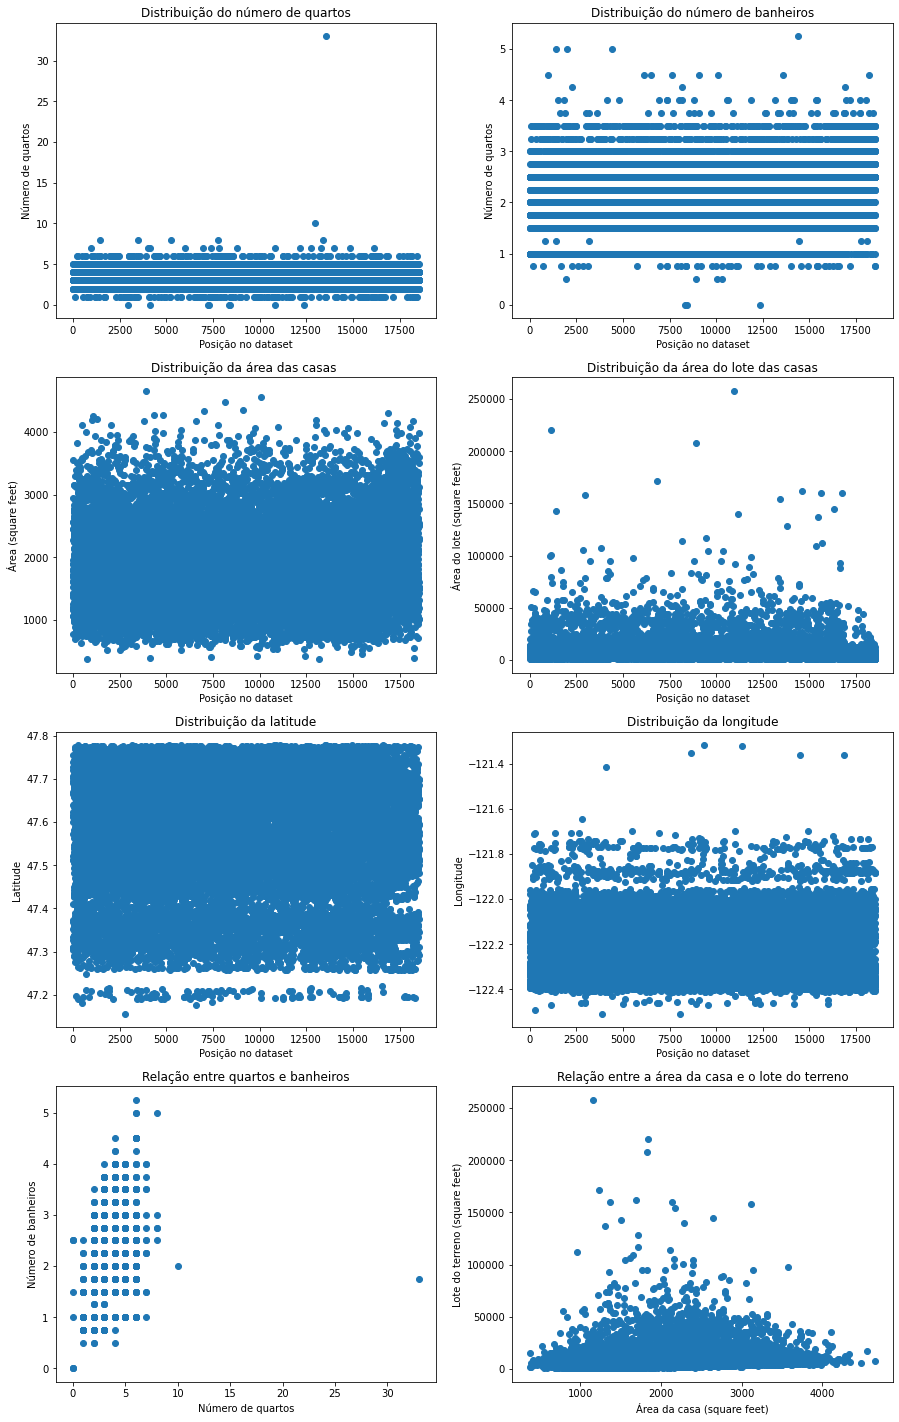

In [10]:
fig = plt.figure(figsize=(15, 25))

numero_linhas = np.arange(0,len(dados.price),1)

#Vendo como as features se comportam dentro do dataset 
plt.subplot(4, 2, 1)
plt.scatter(numero_linhas,dados.bedrooms)
plt.title('Distribuição do número de quartos')
plt.xlabel("Posição no dataset")
plt.ylabel("Número de quartos")

plt.subplot(4, 2, 2)
plt.scatter(numero_linhas,dados.bathrooms)
plt.title('Distribuição do número de banheiros')
plt.xlabel("Posição no dataset")
plt.ylabel("Número de quartos")

plt.subplot(4, 2, 3)
plt.scatter(numero_linhas,dados.sqft_living)
plt.title('Distribuição da área das casas ')
plt.xlabel("Posição no dataset")
plt.ylabel("Área (square feet)")

plt.subplot(4, 2, 4)
plt.scatter(numero_linhas,dados.sqft_lot)
plt.title('Distribuição da área do lote das casas')
plt.xlabel("Posição no dataset")
plt.ylabel("Área do lote (square feet)")

plt.subplot(4, 2, 5)
plt.scatter(numero_linhas,dados.lat)
plt.title('Distribuição da latitude')
plt.xlabel("Posição no dataset")
plt.ylabel("Latitude")

plt.subplot(4, 2, 6)
plt.scatter(numero_linhas,dados.long)
plt.title('Distribuição da longitude')
plt.xlabel("Posição no dataset")
plt.ylabel("Longitude")

#Observando a relação entre o número de quartos e banheiros
plt.subplot(4,2,7)
plt.scatter(dados.bedrooms, dados.bathrooms)
plt.title('Relação entre quartos e banheiros')
plt.xlabel('Número de quartos')
plt.ylabel('Número de banheiros')

#Observando a relação entre a área da casa e o lote do terreno
plt.subplot(4,2,8)
plt.scatter(dados.sqft_living, dados.sqft_lot)
plt.title('Relação entre a área da casa e o lote do terreno')
plt.xlabel('Área da casa (square feet)')
plt.ylabel('Lote do terreno (square feet)')
plt.show()

Visualizando a distribuição de latitude e longitude dentro do dataset:

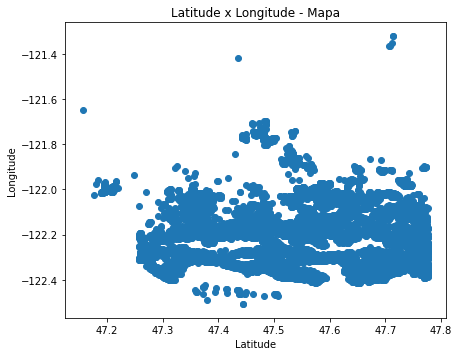

In [11]:
fig = plt.figure(figsize=(15, 25))

plt.subplot(4,2,8)
plt.scatter(dados.lat, dados.long)
plt.title('Latitude x Longitude - Mapa')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

Agora, iremos analisar a coluna do preço:

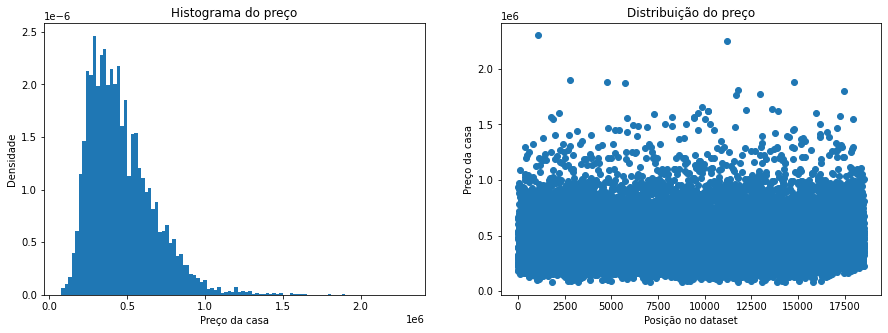

In [12]:
#Plotando as informações em gráficos
fig = plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.hist(dados.price,bins=100,density=True)
plt.title('Histograma do preço')
plt.ylabel('Densidade')
plt.xlabel('Preço da casa')

plt.subplot(1, 2, 2)
faixa_aleatoria = np.arange(0,len(dados.price),1)
plt.scatter(faixa_aleatoria,dados.price)
plt.title('Distribuição do preço')
plt.xlabel('Posição no dataset')
plt.ylabel('Preço da casa')
plt.show()

#### Histograma do preço
O histograma se trata de gráfico que apresenta a distribuição de acordo com a frequência de uma amostra. Pode-se perceber que o histograma está deslocado a esquerda, mostrando que os preços dos dados se concentram até 1.000.000

#### Distribuição do preço
Esse gráfico cada ponto representa o valor de cada casa. Nele também percebe-se a concentração bem acentuada na faixa de 1 milhões e uma concentração mais leve entre 1 milhão e 2 milhões.

Como a variável de interesse para se prever é o preço, foi plotado gráficos cruzando os dados do preço com outras colunas:

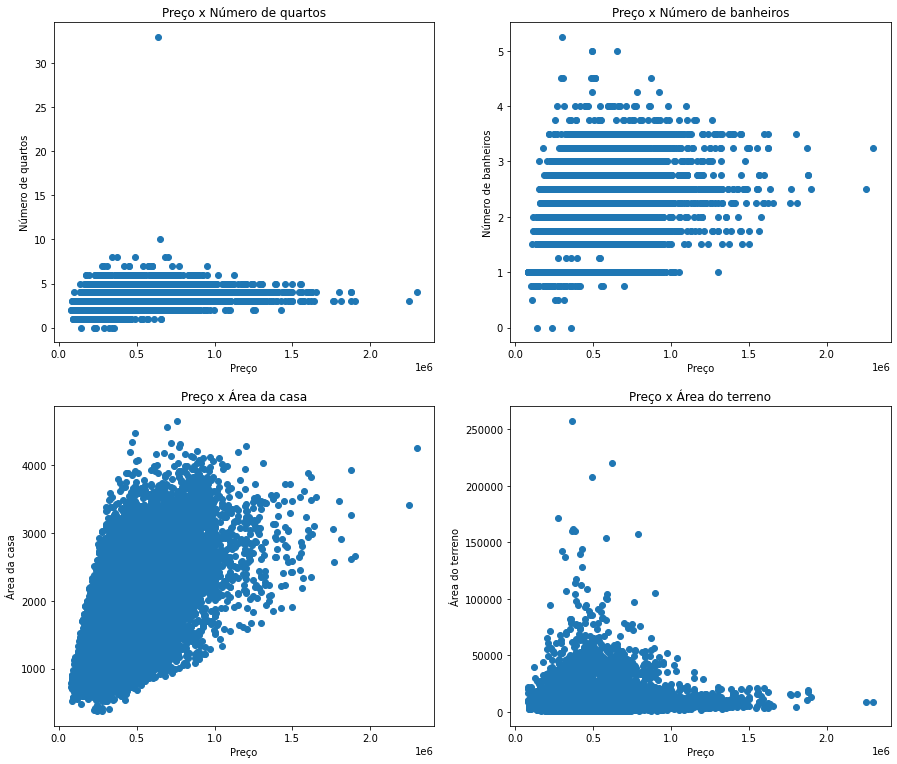

In [13]:
#Plotando as informações em gráficos
fig = plt.figure(figsize=(15, 20))

plt.subplot(3,2,3)
plt.scatter(dados.price, dados.bedrooms)
plt.title('Preço x Número de quartos')
plt.xlabel('Preço')
plt.ylabel('Número de quartos')

plt.subplot(3,2,4)
plt.scatter(dados.price, dados.bathrooms)
plt.title('Preço x Número de banheiros')
plt.xlabel('Preço')
plt.ylabel('Número de banheiros')

plt.subplot(3,2,5)
plt.scatter(dados.price, dados.sqft_living)
plt.title('Preço x Área da casa')
plt.xlabel('Preço')
plt.ylabel('Área da casa')

plt.subplot(3,2,6)
plt.scatter(dados.price, dados.sqft_lot)
plt.title('Preço x Área do terreno')
plt.xlabel('Preço')
plt.ylabel("Área do terreno")
plt.show()

# Predição por Regressão Linear Multipla

Assim como o próprio nome induz, o método faz a predição da variável de interesse (dependente) a partir de uma função **linear** com para cada uma das demais variáveis (independentes). A imagem abaixo apresenta a lei de formação da função: 

<img src="regressãolinear.png" width="360">

Essa função descreve a relação entre as variáveis de forma que a distância de cada relação com a função seja a menor possível, isso é feito por meio da minimização dos resíduos. O resíduo é a distância entro o valor da variável de interesse real do valor previsto pela função obtida. O cálculo do resíduo é feito por meio do **Método dos Mínimos Quadrados (MMQ)** ou, em inglês, _**Ordinary Least Squares**_. 



Definindo variável de interesse (preço) e demais que serão base para a predição:

In [14]:
#A variável de interesse é o preço, por isso selecionamos esta coluna no dataset
Y = dados['price']
#A variáveis dependentes serão bedrooms, bathrooms, sqft_living, sqft_lot, floors, waterfront, view, condition, 
#grade, sqft_above,sqft_basement, yr_built, yr_renovated, lat, long, sqft_living15, sqft_lot15
X = dados[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors','waterfront', 'condition', 'view', 'grade', 'sqft_above','sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long']]

In [15]:
#Printando as colunas que estão em X, apenas para confirmação
X.columns.tolist()

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'condition',
 'view',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'lat',
 'long']

Com a função regress, definida no início do documento, será gerado os resultados com auxílio da função OSL da biblioteca ``statsmodels.api`` 

In [16]:
results = regress(X,Y)

#Os resultados obtidos serão visualizados na tabela a seguir
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                     2268.
Date:                Thu, 11 Jun 2020   Prob (F-statistic):               0.00
Time:                        15:32:55   Log-Likelihood:            -2.4429e+05
No. Observations:               18534   AIC:                         4.886e+05
Df Residuals:                   18519   BIC:                         4.887e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -2.1e+07   1.14e+06    -18.407      0.000   -2.32e+07   -1.88e+07
bedrooms      -1.271e+04   1375.582     -9.241      0.000   -1.54e+04      -1e+04
bathrooms      2.545e+04   2434.765     10.454      0.000    2.07e+04    3.02e+04
sqft_living      69.3141      1.744     39.750      0.000      65.896      72.732
sqft_lot         -0.3655      0.106     -3.441      0.001      -0.574      -0.157
floors          2.01e+04   2591.726      7.755      0.000     1.5e+04    2.52e+04
waterfront      1.82e+05   1.29e+05      1.416      0.157      -7e+04    4.34e+05
condition      2.585e+04   1625.747     15.897      0.000    2.27e+04     2.9e+04
view           3.377e+04   2132.860     15.832      0.000    2.96e+04    3.79e+04
grade           9.02e+04   1534.833     58.767      0.000    8.72e+04    9.32e+04
sqft_above       45.0397      1.693     26.606      0.000      41.722      48.358
sqft_basement    24.2729      2.129     11.404      0.000      20.101      28.445
yr_built      -2045.4234     51.761    -39.516      0.000   -2146.881   -1943.966
yr_renovated      7.5870      3.530      2.150      0.032       0.669      14.505
lat            5.432e+05   7201.145     75.430      0.000    5.29e+05    5.57e+05
long           1.104e+04   8561.738      1.289      0.197   -5745.194    2.78e+04
==============================================================================
Omnibus:                     7077.350   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            58096.368
Skew:                           1.616   Prob(JB):                         0.00
Kurtosis:                      11.049   Cond. No.                     1.97e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.39e-19. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Análise da tabela

Na primeira linha, segunda coluna, da primeira tabela, está o coeficienete de determinação ou R². Ele se trata do coeficiente que apresenta a relação entre a função encontrada e os valores reais, ou seja, o "quão bem" a função acompanha os resultados reais. Ele pode ser obtido por:

$$ R^2 = 1 - \frac{SS_E}{SS_T}$$

Em que SSE e SST são:

$$SQRes=SS_{E}=\sum\limits^{n}_{i=1}(y_i-\hat{y}_i)^2=\sum\limits_{i=1}^{n}\epsilon^2_{i}$$

Lembrando que y é a variável de interesse, o preço da casa. Analisando a fórmula acima conclui-se que SSE é a somatória dos resíduos. Já SST é a somatória dos erros em torno da média, sem a aplciação da regressão:

$$SQT=SS_{T}=\sum\limits^{n}_{i=1}(y_i-\bar{y})^2$$


Dentro dos dados coletados, o **R² obtido é de 64%** assim, evidencia-se que o modelo de regressão linear múltipla não atinge um desempenho considerável, pois, não se aproxima do coeficiente de confiança estabelecido. 

É possível fazer a análise da **Homocedastidade**. Ela indica se o comportamento da variância se mantem a cada valor previsto. Para observá-la é necessário plotar o gráfico do valores preditos com os resíduos (erros), como na célula abaixo:  

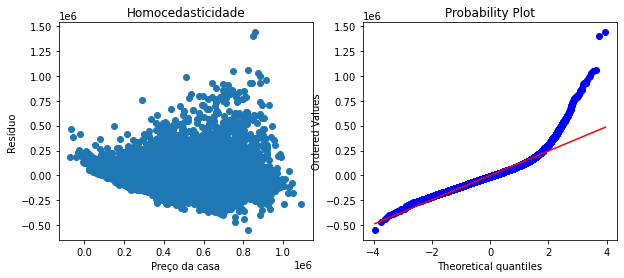

In [17]:
#Armazenando os resíduos obtidos
resultado_reg = results.resid

#Armazenando os valores de preço previstos
y_predict = results.predict(sm.add_constant(X))

fig1 = plt.figure(figsize=(10, 4))
#Verificando a Homocedasticidade
plt.subplot(1,2,1)
plt.scatter(y_predict,resultado_reg)
plt.title("Homocedasticidade")
plt.xlabel("Preço da casa")
plt.ylabel("Resíduo")

#Verificando se os resultados dos residuos obtidos por regressão apresentam distribuição normal
plt.subplot(1,2,2)
stats.probplot(resultado_reg,dist='norm',plot=plt)
plt.show()

Percebe-se que os valores preditos a homocedasticidade varia no modelo, assim, apresenta-se heteroscedasticidade nele. O gráfico da direito também evidência que há variação nos resíduos, pois não seguem a distribuição normal. Os valores de Prob(Omnibus) e Prob(JB) também evidenciam isso pois seus valores, encontrados na terceira tabela, são menores que alpha. 

Outra observação interesse, é sobre os valores-p para cada uma das variáveis independentes. Esse valor-p encontrado, se menor que alpha, mostra que aquela variável é relevante para a determinação do preço. Na tabela obtida, percebe-se que o tamanho do lote em square feet (legendada como sqft_lot) apresenta o valor-p de 0,473, se mostrando pouco relevante na predição do preço. Numa futura análise essa coluna poderia ser excluída, aplicar o modelo novamente para verficar se ele apresenta uma performace melhor.




# Predição por Decision Tree Regressor

Decision Tree Regressor ou Árvore de Decisão por Regressão é um modelo de predição, normalmente, usado quando a variável de interesse é do tipo contínua.  Para chegar no valor previsto ocorre um processo de tomada de decisões que saem de um ponto de partida e se dividem em outros subconjuntos, ou seja ramificações, assim como as raízes de uma árvore. O ponto de partida é o conjunto com todos dados das variáveis influentes sob a variável de interesse, dentro do modelo ele é chamado de nó raiz.  A separação em subconjuntos é chamado de divisão. Já os subconjuntos podem ser nó de decisão ou (conseguirá criar outros subconjuntos) ou nó de término. Quando um nó gera subconjuntos, ele pode ser chamado de nó pai e seus “descendentes”, os subconjuntos, são chamados de nós filhos, assim como na árvore genealógica.  A figura abaixo apresenta como seria a árvore de decisão:

<img src="decisiontree.png" width="500">

Dentro do projeto, o nó raiz são os dados, as sub-árvores são as colunas com as variáveis que interferem para prever o preço da casa e as demais divisões que surgem a partir das colunas e a interação entre elas em cada sub-árvore são feitas na biblioteca sklearn.DecisionTreeRegressor. As próximas células apresentam a implementação da Decision Tree Regressor por meio da biblioteca:


Escolhendo as colunas que serão usadas como parâmetros:

In [18]:
features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long',
       'sqft_living15', 'sqft_lot15']

Renomeando quem será a variável de interesse (preço) e as features. Além de separar o banco de dados entre teste e treinamento:

In [19]:
#selecionando variavel de interesse
y = dados.price
#selecionando os dados com base nas features
x = dados[features]
#separa os dados em treino e validação
xtreino,xvalidacao,ytreino,yvalidacao = train_test_split(x, y, random_state=1)

In [20]:
# Especificando o modelo
modelo_decisiontree = DecisionTreeRegressor()
# Fit do modelo 
modelo_decisiontree.fit(xtreino, ytreino)

DecisionTreeRegressor()

In [27]:
# Especificando o modelo
modelo_decisiontree = DecisionTreeRegressor(random_state=2)
# Fit do modelo 
modelo_decisiontree.fit(xtreino, ytreino)
# Faz a previsão do preço das casas e calcula a média dos erros com base 
val_predictions = modelo_decisiontree.predict(xvalidacao)
val_mae = mean_absolute_error(val_predictions, yvalidacao)
#resultado usando MAE
print(f'Em um primeiro momento, antes da remoção dos outliers o MAE girava em torno de $100.000\n')

print(f'MAE Decision Tree sem outliers: ${val_mae:.2f}\n')

print('Resultado utilizando a função evaluate:\n')
base_accuracy = evaluate(modelo_decisiontree, xvalidacao, yvalidacao)

Em um primeiro momento, antes da remoção dos outliers o MAE girava em torno de $100.000

MAE Decision Tree sem outliers: $73947.28

Resultado utilizando a função evaluate:

Model Performance
Average Error: $73947.28 .
Accuracy = 83.11%.


# Predição por Random Forest

~Explicar sobre o que é e como funciona o método

In [22]:
#criando o modelo usando random forest depois de ja ter tunado
modelo_randomforest = RandomForestRegressor(random_state=1,n_jobs=6,n_estimators=2000,min_samples_split=5,min_samples_leaf=2,max_features='auto',max_depth=50,bootstrap=True)
modelo_randomforest.fit(xtreino, ytreino)
rf_predict = modelo_randomforest.predict(xvalidacao)
rf_mae = mean_absolute_error(rf_predict, yvalidacao)
#resultado utilisando a função MAE
print(f'Random Forest MAE: {rf_mae:.2f}\n')
#resultado utilizando a função evaluate
base_accuracy = evaluate(modelo_randomforest, xvalidacao, yvalidacao)

Random Forest MAE: 51944.13

Model Performance
Average Error: $51944.13 .
Accuracy = 87.98%.


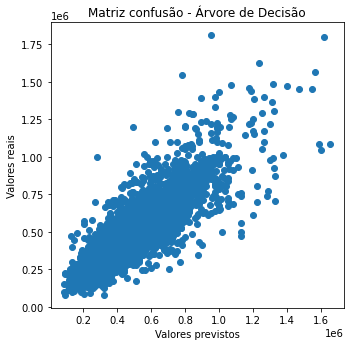

In [23]:
fig1 = plt.figure(figsize=(5.25,5.25))
plt.scatter(val_predictions,yvalidacao)
plt.title("Matriz confusão - Árvore de Decisão")
plt.xlabel("Valores previstos")
plt.ylabel('Valores reais')
plt.show()

# Essa parte foi usada pra tunar o modelo

# Nessa etapa foi feito o teste para ver se houve melhora no resultado, nesse caso aconteceu um incremento de 0.86% de melhora

# Referências

https://www.researchgate.net/profile/Joao_Malere/publication/335392421_Predicao_de_precos_de_imoveis_atraves_de_aprendizagem_de_maquina/links/5d62abce92851c619d76a46e/Predicao-de-precos-de-imoveis-atraves-de-aprendizagem-de-maquina.pdf

http://ibape-nacional.com.br/biblioteca/wp-content/uploads/2012/12/Avaliacao-de-Imoveis-Urbanos-com-Utilizacao-de-Redes-Neurais-Artificiais.pdf

http://www.coordest.ufpr.br/wp-content/uploads/2018/12/TCC_DanielEricson.pdf

https://www.nber.org/papers/w9262.pdf 
